In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score
import mlflow
import mlflow.lightgbm
import logging
import matplotlib.pyplot as plt
import joblib

# Configure logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Load datasets
train_df = pd.read_csv(r"C:\Users\paulo\OneDrive\Documents\Binary-Classification-of-Insurance-Cross-Selling\preprocessed_train.csv")
test_df = pd.read_csv(r"C:\Users\paulo\OneDrive\Documents\Binary-Classification-of-Insurance-Cross-Selling\preprocessed_test.csv")

# Drop ID column from training and test data
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)

logger.info(f"Train dataset shape: {train_df.shape}")
logger.info(f"Test dataset shape: {test_df.shape}")


INFO:__main__:Train dataset shape: (11465233, 11)
INFO:__main__:Test dataset shape: (7669866, 10)


In [3]:
# Create interaction features
interaction_features = train_df.copy()
interaction_features['Age_Annual_Premium'] = train_df['Age'] * train_df['Annual_Premium']
interaction_features['Age_Vintage'] = train_df['Age'] * train_df['Vintage']
interaction_features['Annual_Premium_Vintage'] = train_df['Annual_Premium'] * train_df['Vintage']

logger.info(f"Interaction features created: Age_Annual_Premium, Age_Vintage, Annual_Premium_Vintage")



INFO:__main__:Interaction features created: Age_Annual_Premium, Age_Vintage, Annual_Premium_Vintage


In [4]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(train_df[['Age', 'Annual_Premium', 'Vintage']])
poly_feature_names = poly.get_feature_names_out(['Age', 'Annual_Premium', 'Vintage'])

# Ensure the polynomial feature names are unique and replace spaces with underscores
poly_feature_names_unique = [f"{name.replace(' ', '_')}_{i}" for i, name in enumerate(poly_feature_names)]

poly_df = pd.DataFrame(poly_features, columns=poly_feature_names_unique)

# Concatenate polynomial features with interaction features
train_poly_df = pd.concat([interaction_features, poly_df], axis=1)

# Drop the original columns to prevent duplication and replace spaces with underscores in column names
train_poly_df.columns = train_poly_df.columns.str.replace(' ', '_')
train_poly_df = train_poly_df.loc[:, ~train_poly_df.columns.duplicated()]

logger.info(f"Polynomial features created with degree 2 for Age, Annual_Premium, and Vintage")


INFO:__main__:Polynomial features created with degree 2 for Age, Annual_Premium, and Vintage


In [5]:
# Split the data into train and validation sets
X = train_poly_df.drop(columns=['Response'])
y = train_poly_df['Response']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

logger.info(f"Training set shape: {X_train.shape}")
logger.info(f"Validation set shape: {X_val.shape}")


INFO:__main__:Training set shape: (9172186, 19)
INFO:__main__:Validation set shape: (2293047, 19)


In [7]:
# Set the MLflow tracking URI to the provided local directory
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Define the fine-tuned parameters provided
params = {
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'tree_learner': 'serial',
    'data_sample_strategy': 'bagging',
    'learning_rate': 0.293686,
    'num_leaves': 40,
    'num_threads': 8,
    'max_depth': 12,
    'min_data_in_leaf': 16,
    'min_sum_hessian_in_leaf': 0.001,
    'bagging_fraction': 0.933579,
    'bagging_freq': 4,
    'bagging_seed': 3,
    'feature_fraction': 0.817208,
    'feature_fraction_seed': 2,
    'lambda_l1': 0.126028,
    'lambda_l2': 0.211777,
}

# Train a LightGBM model
with mlflow.start_run():
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[train_data, val_data])
    
    # Log the model with MLflow
    mlflow.lightgbm.log_model(model, "lightgbm-model")

    # Predict on train and validation set
    y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
    y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)

    # Evaluation metrics
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)

    mlflow.log_metric("train_auc", train_auc)
    mlflow.log_metric("val_auc", val_auc)
    
    logger.info(f"Train AUC: {train_auc}")
    logger.info(f"Validation AUC: {val_auc}")


[LightGBM] [Info] Number of positive: 1129070, number of negative: 8043116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2846
[LightGBM] [Info] Number of data points in the train set: 9172186, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123097 -> initscore=-1.963422
[LightGBM] [Info] Start training from score -1.963422


INFO:__main__:Train AUC: 0.8795577939715501
INFO:__main__:Validation AUC: 0.8794696966480825


INFO:__main__:Feature importance saved as feature_importance.csv
INFO:__main__:Feature importance plot saved as feature_importance.png


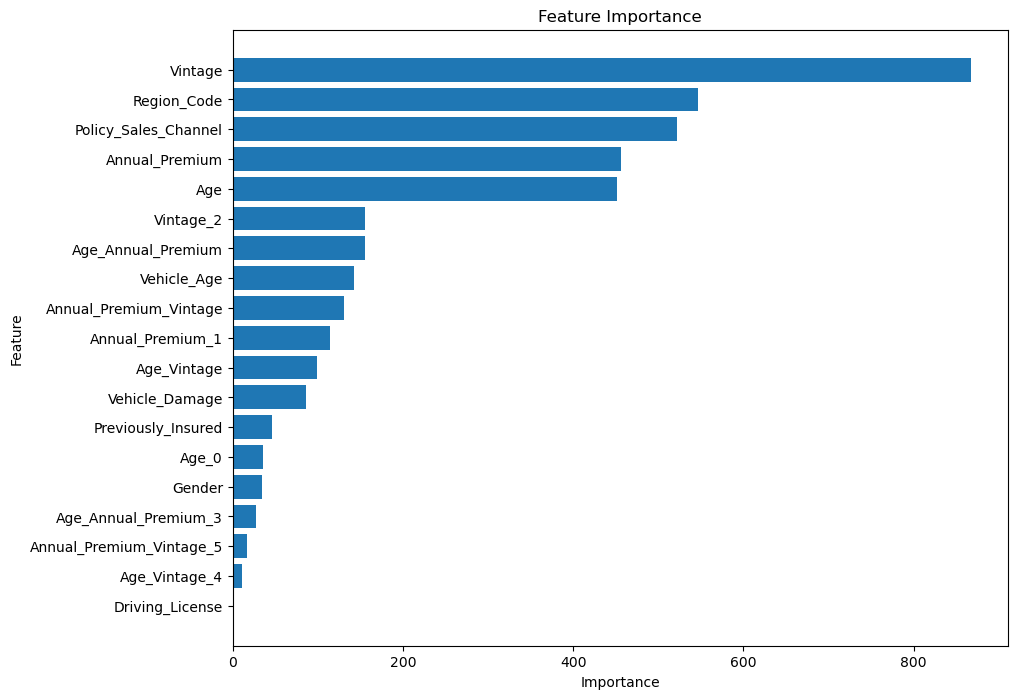

In [8]:
# Feature Importance
importance = model.feature_importance(importance_type='split')
feature_names = model.feature_name()

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

import os

# Define the directory to save files (same directory as the notebook)
save_dir = "."

# Save feature importance to CSV
feature_importance_df.to_csv(os.path.join(save_dir, "feature_importance.csv"), index=False)
logger.info("Feature importance saved as feature_importance.csv")

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(save_dir, "feature_importance.png"))
logger.info("Feature importance plot saved as feature_importance.png")

In [9]:
# Save the model and metrics
import joblib

joblib.dump(model, os.path.join(save_dir, "lightgbm_model.pkl"))
logger.info("Model saved as lightgbm_model.pkl")

metrics = {
    "train_auc": train_auc,
    "val_auc": val_auc
}

metrics_df = pd.DataFrame(metrics, index=[0])
metrics_df.to_csv(os.path.join(save_dir, "model_metrics.csv"), index=False)
logger.info("Model metrics saved as model_metrics.csv")

INFO:__main__:Model saved as lightgbm_model.pkl
INFO:__main__:Model metrics saved as model_metrics.csv
